### Model Agonostic Meta-Learning (MAML) -- Regression example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import pdb
import os 
import data
import maml
import regressors
from collections import OrderedDict
import copy

from model import *
from utils import *

import time

In [2]:
gen_train = data.SinusoidGenerator(batch_size = 64,
                 num_tasks = 512,
                 x_range = (-5, 5),
                 A_range = (0.1, 5),
                 P_range = (0, np.pi),
                 min_support_points=10,
                 max_support_points=10,
                 min_query_points=10,
                 max_query_points=10,
                 permute_inds = True)

gen_test = data.SinusoidGenerator(batch_size = 64,
                 num_tasks = 128,
                 x_range = (-5, 5),
                 A_range = (0.1, 5),
                 P_range = (0, np.pi),
                 min_support_points=5,
                 max_support_points=5,
                 min_query_points=5,
                 max_query_points=5,
                 permute_inds = True)

In [3]:
train_task = gen_train.generate_task()
task = train_task

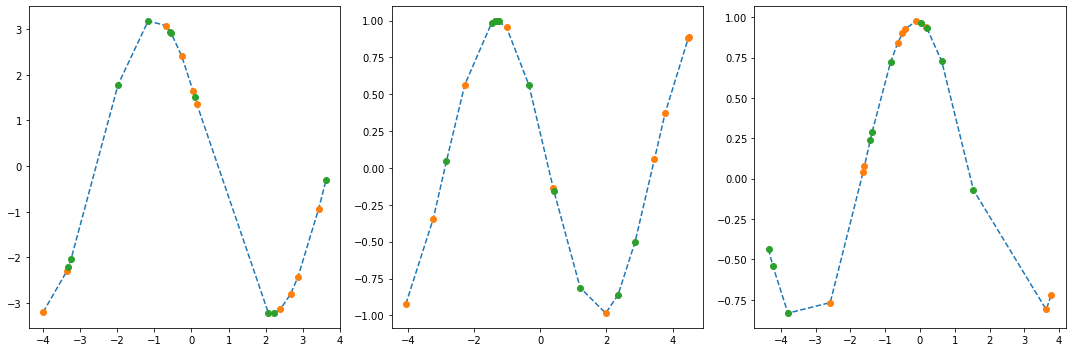

In [4]:
n_rows = 1
n_cols = 3

fig, axes = plt.subplots(n_rows,n_cols,figsize=(5*n_cols,5*n_rows))

for idx, ax in enumerate(axes.flatten()):
    x = task['x'][idx,:,:].cpu()
    y = task['y'][idx,:,:].cpu()
    xc = task['x_support'][idx,:,:].cpu()
    yc = task['y_support'][idx,:,:].cpu()
    xt = task['x_query'][idx,:,:].cpu()
    yt = task['y_query'][idx,:,:].cpu()
    
    ax.plot(x,y,'--')
    ax.plot(xc,yc,'o')
    ax.plot(xt,yt,'o')
    #ax.title.set_text(idx)
    #ax.set_xlim(-5,5)
    plt.tight_layout()

In [5]:
%%capture
#fig, axes = plt.subplots(3,3,figsize=(20,15))
fig = plt.figure(figsize=(15,5))
for idx in range(task['x'].shape[0]):
    xc = task['x_support'][idx,:,:].cpu()
    yc = task['y_support'][idx,:,:].cpu()
    xt = task['x_query'][idx,:,:].cpu()
    yt = task['y_query'][idx,:,:].cpu()
    plt.plot(xc,yc,'o--')
    #ax.title.set_text(idx)
    #ax.set_xlim(-5,5)
    plt.tight_layout()

In [6]:
def plot_example(task, num_plots, model, epoch, num_inner_updates=1):
    
    fig, axes = plt.subplots(1,num_plots, figsize=(20,5))
    
    for idx, ax in enumerate(axes.flatten()):
        
        test_model = copy.deepcopy(model)
        
        x_supports = task['x_support']
        y_supports = task['y_support']

        x_queries = task['x_query']
        y_queries = task['y_query']
        
        with torch.enable_grad():
            updated_params = OrderedDict(test_model.regressor.named_parameters())
            for update_idx in range(num_inner_updates):
                updated_params = test_model._inner_loop_train(x_supports[idx], y_supports[idx], alpha, updated_params)
        
        ##updated_params = test_model._inner_loop_train(x_supports[idx], y_supports[idx], alpha, )
        
        with torch.no_grad():

            # Collect predictions for query sets, using model updated params for specific task
            prior_query_predictions = test_model.regressor(x_queries[idx],OrderedDict(test_model.regressor.named_parameters()))
            prior_query_Loss = F.mse_loss(prior_query_predictions, y_queries[idx])
            
            updated_query_predictions = test_model.regressor(x_queries[idx], updated_params)
            updated_query_loss = F.mse_loss(updated_query_predictions, y_queries[idx])
            
            # Collect predictions for test set
            x_test = torch.unsqueeze(torch.tensor(np.linspace(-5,5), dtype=torch.float32, device=device),1)
            
            prior_predictions = test_model.regressor(x_test,OrderedDict(test_model.regressor.named_parameters()))
            updated_predictions = test_model.regressor(x_test,updated_params)
        
        ax.plot(x_supports[idx].cpu(),y_supports[idx].cpu(), 'o')
        ax.plot(x_queries[idx].cpu(),y_queries[idx].cpu(), 'o')
        
        ax.plot(x_queries[idx].cpu(), prior_query_predictions.cpu(), 'xg')
        ax.plot(x_test.cpu(), prior_predictions.cpu(), '--g')
        
        ax.plot(x_queries[idx].cpu(), updated_query_predictions.cpu(), 'xb')
        ax.plot(x_test.cpu(), updated_predictions.cpu(), '--b')
        
        ax.set_title("Epoch: {}: prior loss {:.2f}: {}x updated loss {:.2f}".format(epoch, prior_query_Loss, num_inner_updates, updated_query_loss))
    
    plt.show()

In [7]:
model = ModelMLPSinusoid().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=.01)
meta_model = maml.MAML_trainer(model, optimizer)
alpha=0.01

In [8]:
test_task = gen_test.generate_task()

In [9]:
def run_epoch(gen,meta_model,num_inner_updates=1, train=True):
    
    avg_loss = RunningAverage()
    avg_prior_loss = RunningAverage()
    
    for idx, task in enumerate(gen):
        
        loss, prior_loss = meta_model.outer_loop_train(task['x_support'],
                          task['y_support'],
                          task['x_query'],
                          task['y_query'],
                          num_inner_updates=num_inner_updates,
                          train=train
                          )
        
        with torch.no_grad():
            avg_loss.update(loss, gen.batch_size)     
            avg_prior_loss.update(prior_loss, gen.batch_size)
    
    return avg_loss, avg_prior_loss

In [10]:
num_epochs = 50

losses = []
prior_losses = []

test_losses = []
test_prior_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    avg_loss, avg_prior_loss = run_epoch(gen_train, meta_model, num_inner_updates=1, train=True)

    losses.append(avg_loss.avg)
    prior_losses.append(avg_prior_loss.avg)

    elapsed_time = time.time() - start_time
    
    print(f"Train ¦ Epoch : {epoch} ¦ Prior loss : {float(avg_prior_loss.avg):.2f} ¦ Updated loss : {float(avg_loss.avg):.2f} ¦ Time : {elapsed_time:.2f}")

    if (epoch % 10) == 0:

        for n in [1, 5 ,10]:

            start_time = time.time()

            test_avg_loss, test_avg_prior_loss = run_epoch(gen_test, meta_model,num_inner_updates=n, train=False)

            test_losses.append(test_avg_loss.avg)
            test_prior_losses.append(test_avg_prior_loss.avg)

            elapsed_time = time.time() - start_time

            print(f"Test ¦ Epoch : {epoch} ¦ Prior loss : {float(test_avg_prior_loss.avg):.2f} ¦ {n}x Updated loss : {float(test_avg_loss.avg):.2f} ¦Time : {elapsed_time:.2f}")

            num_plots = 3

            #plot_example(test_task, num_plots, meta_model, epoch)
            #plot_example(test_task, num_plots, meta_model, epoch, num_inner_updates=5)
            #plot_example(test_task, num_plots, meta_model, epoch, num_inner_updates=10)


Train ¦ Epoch : 0 ¦ Prior loss : 3.55 ¦ Updated loss : 1.50 ¦ Time : 67.27
Test ¦ Epoch : 0 ¦ Prior loss : 4.58 ¦ 1x Updated loss : 1.27 ¦Time : 14.62
Test ¦ Epoch : 0 ¦ Prior loss : 4.55 ¦ 5x Updated loss : 0.77 ¦Time : 47.57
Test ¦ Epoch : 0 ¦ Prior loss : 4.55 ¦ 10x Updated loss : 0.71 ¦Time : 90.40
Train ¦ Epoch : 1 ¦ Prior loss : 3.93 ¦ Updated loss : 0.72 ¦ Time : 67.08
Train ¦ Epoch : 2 ¦ Prior loss : 4.21 ¦ Updated loss : 0.66 ¦ Time : 66.83
Train ¦ Epoch : 3 ¦ Prior loss : 3.74 ¦ Updated loss : 0.56 ¦ Time : 66.68
Train ¦ Epoch : 4 ¦ Prior loss : 3.54 ¦ Updated loss : 0.51 ¦ Time : 66.93
Train ¦ Epoch : 5 ¦ Prior loss : 3.72 ¦ Updated loss : 0.50 ¦ Time : 66.77
Train ¦ Epoch : 6 ¦ Prior loss : 3.85 ¦ Updated loss : 0.51 ¦ Time : 66.64
Train ¦ Epoch : 7 ¦ Prior loss : 4.10 ¦ Updated loss : 0.53 ¦ Time : 67.07
Train ¦ Epoch : 8 ¦ Prior loss : 3.54 ¦ Updated loss : 0.46 ¦ Time : 66.75
Train ¦ Epoch : 9 ¦ Prior loss : 3.66 ¦ Updated loss : 0.47 ¦ Time : 66.72
Train ¦ Epoch : 10 ¦ 

In [13]:
folder = r'C:\Google Drive (mg963)\PhD\MLMI4\maml4mlmi4\Regression\_experiments\results'
filename = 'model.pt'

PATH = os.path.join(folder, filename)
torch.save(model.state_dict(), PATH)

In [20]:
gen_test.num_tasks = 512
for n in [1,5,10]:
    start_time = time.time()
    test_avg_loss, test_avg_prior_loss = run_epoch(gen_test, meta_model,num_inner_updates=n, train=False)
    elapsed_time = time.time() - start_time
    print(f"Test ¦ Epoch : {epoch} ¦ Prior loss : {float(test_avg_prior_loss.avg):.2f} ¦ {n}x Updated loss : {float(test_avg_loss.avg):.2f} ¦Time : {elapsed_time:.2f}")

Test ¦ Epoch : 49 ¦ Prior loss : 3.29 ¦ 1x Updated loss : 0.71 ¦Time : 59.11
Test ¦ Epoch : 49 ¦ Prior loss : 3.27 ¦ 5x Updated loss : 0.38 ¦Time : 192.98
Test ¦ Epoch : 49 ¦ Prior loss : 3.27 ¦ 10x Updated loss : 0.34 ¦Time : 369.84


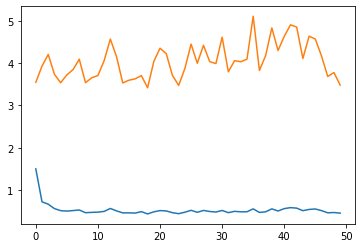

In [21]:
plt.plot(losses)
plt.plot(prior_losses)
plt.show()

In [ ]:
def test(task, idx, model, optimizer, epoch):

    xc = task['x_support'][idx,:,:]
    yc = task['y_support'][idx,:,:]
    xt = task['x_query'][idx,:,:]
    yt = task['y_query'][idx,:,:]
    
    model.train()    
    # Forward pass using support sets
    optimizer = torch.optim.Adam(model.parameters(), lr=.01)
    predictions = model(xc)
    loss = F.mse_loss(predictions, yc)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        pred = model(xt)
        after_loss = F.mse_loss(predictions, yt)
    return pred, loss, after_loss


def test_inner_loop(task, idx, model, epoch, alpha=alpha):
    
    xc = task['x_support'][idx,:,:]
    yc = task['y_support'][idx,:,:]
    xt = task['x_query'][idx,:,:]
    yt = task['y_query'][idx,:,:]
    
    # Copy regressor to store updated params-> we don't want to update the actual meta-model
    updated_model = copy.deepcopy(model)
    #updated_model_params = updated_model.named_parameters()
    
    # Forward pass using support sets
    pred_c = updated_model(xc)
    pred_t_before = updated_model(xt)
    
    loss_target = F.mse_loss(pred_t_before, yt)
    loss_context = F.mse_loss(pred_c, yc)
    loss_context.backward()

    state_dict = updated_model.state_dict()
    
    with torch.no_grad():
        # Manual backward pass
        for name, param in updated_model.named_parameters():
            grad = param.grad
            if grad is None:
                new_param = param
            else:
                new_param = param - alpha * grad.data # gradient descent

            state_dict[name] = new_param

        updated_model.load_state_dict(state_dict)
    
        # Forward pass with updated model parameters
        pred_t = updated_model(xt)
        updated_loss_target = F.mse_loss(pred_t, yt)
        
        x_test = torch.unsqueeze(torch.tensor(np.linspace(-5,5), dtype=torch.float32, device=device),1)
        y_test = updated_model(x_test)
        
    return pred_t, loss_target, updated_loss_target, x_test, y_test